# Training an Anomalous Jet Detector with **VAE** 

---
In this notebook, we train an unsupervised algorithm capable of compressing a jet features into a low-dimension laten space and, from there, reconstruct the input data. The distance between the input and the output is used to identify rare jets. Applying a lower treshold on the loss, one can veto standard QCD jets (quarks and gluons) and select a sample enriched in anomalous jets (W, Z, top, etc). 

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [3]:
! git clone https://github.com/pierinim/tutorials.git

fatal: destination path 'tutorials' already exists and is not an empty directory.


In [4]:
! ls tutorials/Data/JetDataset/

jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [5]:
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]], dtype=np.float32)
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]


Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 16)


In [6]:
# we standardize the data, so that the mean is = 0 and rms = 1 
from sklearn.preprocessing import StandardScaler
print(np.mean(features[:,10]), np.var(features[:,10]))
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
print(np.mean(features[:,10]), np.var(features[:,10]))

0.089908905 0.001333433
3.77655e-09 1.0


We now separate the dataset in 4:
- a training dataset, consisting of quarks and gluons
- three 'anomalous jets' samples: W, Z, and top

In [7]:
features_standard = features[np.argmax(target,axis=1)<2]
features_W = features[np.argmax(target,axis=1)==2]
features_Z = features[np.argmax(target,axis=1)==3]
features_t = features[np.argmax(target,axis=1)==4]
print(features_standard.shape, features_W.shape, features_Z.shape, features_t.shape)

(19908, 16) (10015, 16) (10037, 16) (10040, 16)


Notice that this is an unsupervised algorithm, so we don't need the target array anymore.
Nevertheless, we keep a part of it around, since it might be useful to test the response 
of the algorithm to quarks and gluons separetly

In [8]:
label_standard = target[np.argmax(target,axis=1)<2]

We now shuffle the standard-jet data and its labels, splitting them into a training, a validation+test dataset with 2:1:1 ratio. 

Then we separate the validation+test in two halves (training and validation)

In [9]:
from sklearn.model_selection import train_test_split
X_learn, X_test, label_learn, label_test = train_test_split(features_standard, label_standard, test_size=0.2)
print(X_learn.shape, X_test.shape, label_learn.shape, label_test.shape)
X_train, X_val, label_train, label_val = train_test_split(X_learn, label_learn, test_size=0.2)
print(X_train.shape, X_val.shape, label_train.shape, label_val.shape, label_test.shape)
del features_standard, label_standard, features, target, X_learn, label_learn

(15926, 16) (3982, 16) (15926, 5) (3982, 5)
(12740, 16) (3186, 16) (12740, 5) (3186, 5) (3982, 5)


# Building the VAE model

In [10]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Layer
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import setGPU

setGPU: Setting GPU to: 2


In [11]:
def sample_z(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    eps = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var / 2) * eps

Loss definition: The first block of code is just the reconstruction error which is given by the cross-entropy. The second block of code calculates the KL-divergence analytically and adds it to the loss function with the line self.add_loss. It represents the KL-divergence as just another layer in the neural network with the inputs equal to the outputs (means and variances in latent space)

In [12]:
from tensorflow.keras import backend as K

# Define loss
def myloss(y_true, y_pred):
    # mse
    sum_sq = (y_true-y_pred)*(y_true-y_pred)
    return K.sum(sum_sq, axis=-1)

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)
        self.beta = args[0]
        
    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - self.beta * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

In [13]:
def vae(input_dim, latent_dim, beta):
    #encoder
    input_encoder = Input(shape=(input_dim), name='encoder_input')
    x = Dense(10, activation='elu')(input_encoder)
    z_mu = Dense(latent_dim, name='latent_mu')(x)
    z_log_var = Dense(latent_dim, name='latent_logvar')(x)
    z_mu, z_log_var = KLDivergenceLayer(beta)([z_mu, z_log_var])
    
    z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_log_var])
    encoder = Model(inputs=input_encoder, outputs=[z_mu, z_log_var, z], name='encoder')
    encoder.summary()
    
    #decoder
    input_decoder = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(10, activation='elu')(input_decoder)
    dec = Dense(input_dim, activation='linear')(x)    
    decoder = Model(inputs=input_decoder, outputs=dec, name='decoder_CNN')
    decoder.summary()
 
    #vae
    vae_outputs = decoder(encoder(input_encoder)[2])
    vae = Model(input_encoder, vae_outputs, name='vae')
    vae.summary()
    
    return vae, encoder

In [14]:
model, encoder = vae(16, 5, 0.5)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           170         encoder_input[0][0]              
__________________________________________________________________________________________________
latent_mu (Dense)               (None, 5)            55          dense[0][0]                      
__________________________________________________________________________________________________
latent_logvar (Dense)           (None, 5)            55          dense[0][0]                      
____________________________________________________________________________________________

In [15]:
model.compile(optimizer='adam', loss=myloss)

In [16]:
n_epochs = 200
batch_size = 128
# train 
history = model.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, X_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
100/100 - 0s - loss: 19.0284 - val_loss: 14.5228
Epoch 2/200
100/100 - 0s - loss: 12.3901 - val_loss: 10.7877
Epoch 3/200
100/100 - 0s - loss: 9.8454 - val_loss: 9.3410
Epoch 4/200
100/100 - 0s - loss: 8.9484 - val_loss: 8.6558
Epoch 5/200
100/100 - 0s - loss: 8.2317 - val_loss: 8.0655
Epoch 6/200
100/100 - 0s - loss: 7.7758 - val_loss: 7.5814
Epoch 7/200
100/100 - 0s - loss: 7.4210 - val_loss: 7.3099
Epoch 8/200
100/100 - 0s - loss: 7.1891 - val_loss: 7.1483
Epoch 9/200
100/100 - 0s - loss: 6.9790 - val_loss: 6.8444
Epoch 10/200
100/100 - 0s - loss: 6.7929 - val_loss: 6.7889
Epoch 11/200
100/100 - 0s - loss: 6.6628 - val_loss: 6.6958
Epoch 12/200
100/100 - 0s - loss: 6.5770 - val_loss: 6.5576
Epoch 13/200
100/100 - 0s - loss: 6.4604 - val_loss: 6.4420
Epoch 14/200
100/100 - 0s - loss: 6.3650 - val_loss: 6.3965
Epoch 15/200
100/100 - 0s - loss: 6.2640 - val_loss: 6.2645
Epoch 16/200
100/100 - 0s - loss: 6.1855 - val_loss: 6.1139
Epoch 17/200
100/100 - 0s - loss: 6.0936 - va

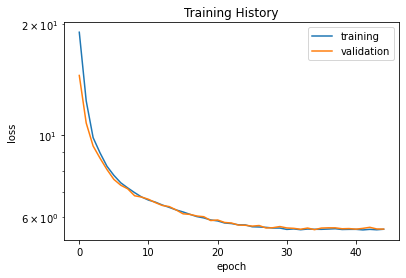

In [17]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Loss Distributions

In [18]:
labels = ['W', 'Z', 'top']

In [19]:
anomaly = [features_W, features_Z, features_t]
predictedQCD = model.predict(X_test)
predicted_anomaly = []
for i in range(len(labels)):
    predicted_anomaly.append(model.predict(anomaly[i]))

In [20]:
def mse(data_in, data_out):
    mse = (data_out-data_in)*(data_out-data_in)
    # sum over features
    mse = mse.sum(-1)
    return mse    

In [21]:
lossQCD = mse(X_test, predictedQCD)
loss_anomaly = []
for i in range(len(labels)):
    loss_anomaly.append(mse(anomaly[i], predicted_anomaly[i]))

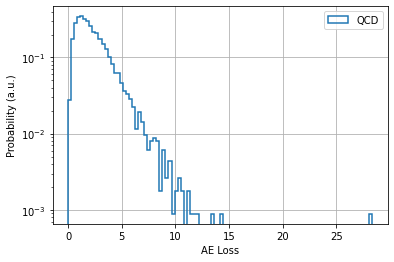

In [22]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

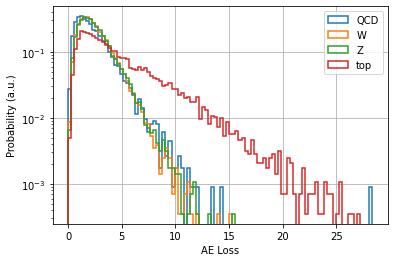

In [23]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
for i in range(len(labels)):
    plt.hist(loss_anomaly[i], bins=100, label=labels[i], density=True, range=(0, maxScore),
            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Building the ROC Curves

(10015,) (3982,)
(13997,) (13997,)
(10037,) (3982,)
(14019,) (14019,)
(10040,) (3982,)
(14022,) (14022,)


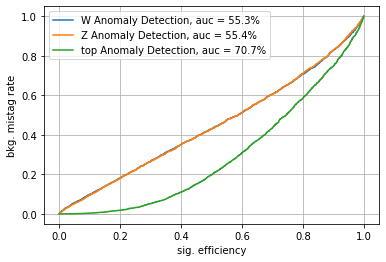

In [24]:
from sklearn.metrics import roc_curve, auc
plt.figure()
targetQCD = np.zeros(lossQCD.shape[0])
for i, label in enumerate(labels):
        print(loss_anomaly[i].shape, targetQCD.shape)
        trueVal = np.concatenate((np.ones(loss_anomaly[i].shape[0]),targetQCD))
        predVal = np.concatenate((loss_anomaly[i],lossQCD))
        print(trueVal.shape, predVal.shape)
        fpr, tpr, threshold = roc_curve(trueVal,predVal)
        auc1= auc(fpr, tpr)
        plt.plot(tpr,fpr,label='%s Anomaly Detection, auc = %.1f%%'%(label,auc1*100.))
#plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()